In [ ]:
from google.colab import files
uploaded = files.upload()

!unzip archive.zip -d /content/dataset



Saving archive.zip to archive.zip
Archive:  archive.zip
  inflating: /content/dataset/1.xml  
  inflating: /content/dataset/10.xml  
  inflating: /content/dataset/100.xml  
  inflating: /content/dataset/100_1.jpg  
  inflating: /content/dataset/101.xml  
  inflating: /content/dataset/101_1.jpg  
  inflating: /content/dataset/102.xml  
  inflating: /content/dataset/102_1.jpg  
  inflating: /content/dataset/103.xml  
  inflating: /content/dataset/103_1.jpg  
  inflating: /content/dataset/104.xml  
  inflating: /content/dataset/104_1.jpg  
  inflating: /content/dataset/105.xml  
  inflating: /content/dataset/105_1.jpg  
  inflating: /content/dataset/106.xml  
  inflating: /content/dataset/106_1.jpg  
  inflating: /content/dataset/106_2.jpg  
  inflating: /content/dataset/106_3.jpg  
  inflating: /content/dataset/106_4.jpg  
  inflating: /content/dataset/107.xml  
  inflating: /content/dataset/107_1.jpg  
  inflating: /content/dataset/108.xml  
  inflating: /content/dataset/108_1.jpg  
  i

In [ ]:
!pip install scikit-image

**Generating polygon masks from SVG point data stored in XML files and save as Image**

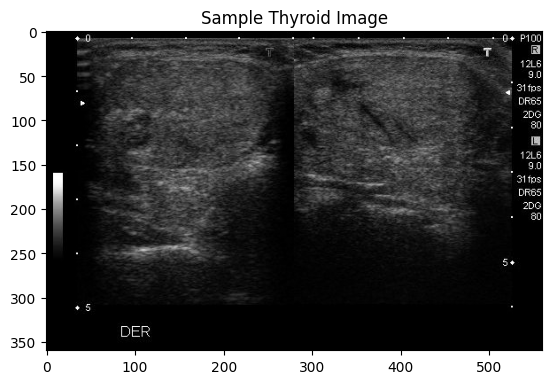

In [ ]:
import os
sample_image_path = '/content/dataset/100_1.jpg'
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_image, cmap='gray')
plt.title('Sample Thyroid Image')
plt.show()

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import json
import cv2
import numpy as np

# Paths
data_path = './dataset/'         # XML and images directory
save_path = '/content/drive/MyDrive/mask_images/'     # Directory to save mask images

# Delete old mask folder if exists
if os.path.exists(save_path):
    shutil.rmtree(save_path)

# Create a fresh mask folder
os.makedirs(save_path)

# Helper function to create polygon mask
def create_mask_from_points(points, shape):
    mask = np.zeros(shape[:2], dtype=np.uint8)
    pts = np.array([[pt["x"], pt["y"]] for pt in points], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [pts], 255)
    return mask

# Process each XML file
for file_name in os.listdir(data_path):
    if file_name.endswith('.xml'):
        xml_path = os.path.join(data_path, file_name)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        marks = root.findall("mark")
        for mark in marks:
            image_id = mark.find("image").text
            svg_text = mark.find("svg").text

            # Skip if svg_text is missing or empty
            if not svg_text:
                print(f"Skipped: No SVG data in {file_name}")
                continue

            try:
                svg_data = json.loads(svg_text)
                for i, shape_data in enumerate(svg_data):
                    points = shape_data["points"]
                    image_file = f'{root.find("number").text}_{image_id}.jpg'
                    image_path = os.path.join(data_path, image_file)
                    if os.path.exists(image_path):
                        img = cv2.imread(image_path)
                        mask = create_mask_from_points(points, img.shape)
                        mask_filename = os.path.join(save_path, f'{os.path.splitext(image_file)[0]}_mask.png')
                        cv2.imwrite(mask_filename, mask)
                    else:
                        print(f"Image not found: {image_file}")
            except json.JSONDecodeError:
                print(f"Failed to decode JSON from SVG in {file_name}")


Failed to decode JSON from SVG in 197.xml
Failed to decode JSON from SVG in 166.xml
Skipped: No SVG data in 230.xml
Skipped: No SVG data in 389.xml
Failed to decode JSON from SVG in 203.xml
Failed to decode JSON from SVG in 127.xml
Skipped: No SVG data in 213.xml
Skipped: No SVG data in 142.xml
Failed to decode JSON from SVG in 54.xml
Skipped: No SVG data in 120.xml
Skipped: No SVG data in 62.xml
Failed to decode JSON from SVG in 165.xml
Failed to decode JSON from SVG in 176.xml
Failed to decode JSON from SVG in 205.xml


**Create two Images and Mask folders**

In [ ]:
import os
import shutil

# Define folders
images_folder = '/content/drive/MyDrive/images'
masks_folder = '/content/drive/MyDrive/masks'

# Create folders if not exist
os.makedirs(images_folder, exist_ok=True)
os.makedirs(masks_folder, exist_ok=True)

# Move images (.jpg) from dataset root to images_folder
for file in os.listdir('/content/dataset'):
    if file.endswith('.jpg'):
        shutil.copy(os.path.join('/content/dataset', file), os.path.join(images_folder, file))

# Move masks (_mask.png) from mask_images folder to masks_folder
for file in os.listdir('/content/mask_images'):
    if file.endswith('_mask.png'):
        shutil.copy(os.path.join('/content/mask_images', file), os.path.join(masks_folder, file))


In [ ]:
for file in os.listdir(masks_folder):
    if file.endswith('_mask.png'):
        new_name = file.replace('_mask', '')
        os.rename(os.path.join(masks_folder, file), os.path.join(masks_folder, new_name))


In [ ]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    filenames = []  # <-- Add this line

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(image_dir, filename)
            base_name = os.path.splitext(filename)[0]
            mask_filename = base_name + '.png'
            mask_path = os.path.join(mask_dir, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Mask not found for: {filename} — Expected: {mask_filename}")
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Could not read image: {img_path}")
                continue
            if mask is None:
                print(f"Could not read mask: {mask_path}")
                continue

            img = cv2.resize(img, img_size) / 255.0
            mask = cv2.resize(mask, img_size) / 255.0

            images.append(img)
            masks.append(mask)
            filenames.append(filename)  # <-- Save filename

    print(f"\n✅ Successfully loaded {len(images)} images and {len(masks)} masks.\n")
    images = np.expand_dims(np.array(images), axis=-1)
    masks = np.expand_dims(np.array(masks), axis=-1)
    return images, masks, filenames



IMAGE_PATH = '/content/drive/MyDrive/images'
MASK_PATH = '/content/drive/MyDrive/masks'
images, masks, filenames = load_data(IMAGE_PATH, MASK_PATH)


Mask not found for: 142_2.jpg — Expected: 142_2.png
Mask not found for: 120_1.jpg — Expected: 120_1.png
Mask not found for: 230_2.jpg — Expected: 230_2.png
Mask not found for: 127_1.jpg — Expected: 127_1.png
Mask not found for: 62_3.jpg — Expected: 62_3.png
Mask not found for: 166_1.jpg — Expected: 166_1.png
Mask not found for: 213_2.jpg — Expected: 213_2.png
Mask not found for: 176_1.jpg — Expected: 176_1.png
Mask not found for: 389_1.jpg — Expected: 389_1.png
Mask not found for: 203_1.jpg — Expected: 203_1.png
Mask not found for: 165_1.jpg — Expected: 165_1.png
Mask not found for: 205_1.jpg — Expected: 205_1.png
Mask not found for: 197_1.jpg — Expected: 197_1.png
Mask not found for: 54_1.jpg — Expected: 54_1.png

✅ Successfully loaded 466 images and 466 masks.



In [ ]:
print("Total images loaded:", len(images))
print("Total masks loaded:", len(masks))

Total images loaded: 466
Total masks loaded: 466


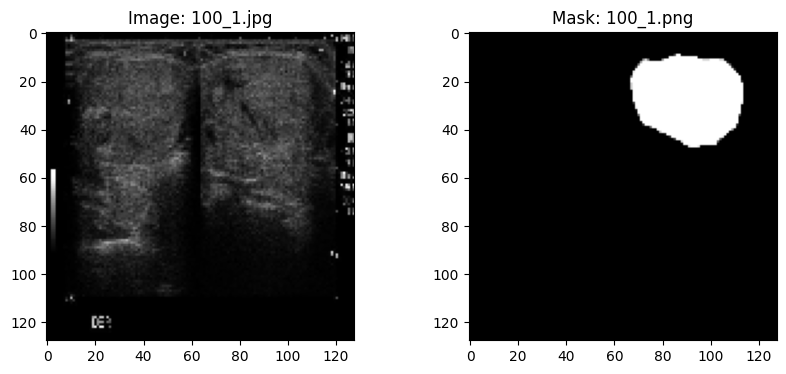

In [ ]:
# Find index of image '100_1.jpg'
target_filename = '100_1.jpg'
if target_filename in filenames:
    idx = filenames.index(target_filename)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("Image: 100_1.jpg")
    plt.imshow(images[idx].squeeze(), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Mask: 100_1.png")
    plt.imshow(masks[idx].squeeze(), cmap='gray')

    plt.show()
else:
    print(f"{target_filename} not found in loaded filenames.")

**Define Unet Model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs=[inputs], outputs=[outputs])

# Create and compile the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 64, 64,    │    131,200 │ conv2d_19[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 128, 128,  │     32,832 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │         65 │ conv2d_21[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 902,593 (3.44 MB)

 Trainable params: 902,593 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 17s/step - accuracy: 0.9315 - loss: 0.2018 - val_accuracy: 0.9233 - val_loss: 0.2096
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 258s 17s/step - accuracy: 0.9352 - loss: 0.1912 - val_accuracy: 0.9233 - val_loss: 0.2086
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 203s 17s/step - accuracy: 0.9312 - loss: 0.1993 - val_accuracy: 0.9233 - val_loss: 0.2036
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 201s 17s/step - accuracy: 0.9286 - loss: 0.1942 - val_accuracy: 0.9233 - val_loss: 0.2016
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 17s/step - accuracy: 0.9321 - loss: 0.1840 - val_accuracy: 0.9233 - val_loss: 0.1990
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 202s 17s/step - accuracy: 0.9344 - loss: 0.1834 - val_accuracy: 0.9233 - val_loss: 0.2077
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 201s 17s/step - accuracy: 0.9290 - loss: 0.1910 - val_accuracy: 0.9233 - val_loss: 0.1931
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 203s 17s/step - accuracy: 0.9293 - loss: 0.1911 - val_accuracy: 0.

**Save Model**

In [ ]:
model.save('thyriod_segmentation_model.h5')

**Plotting**

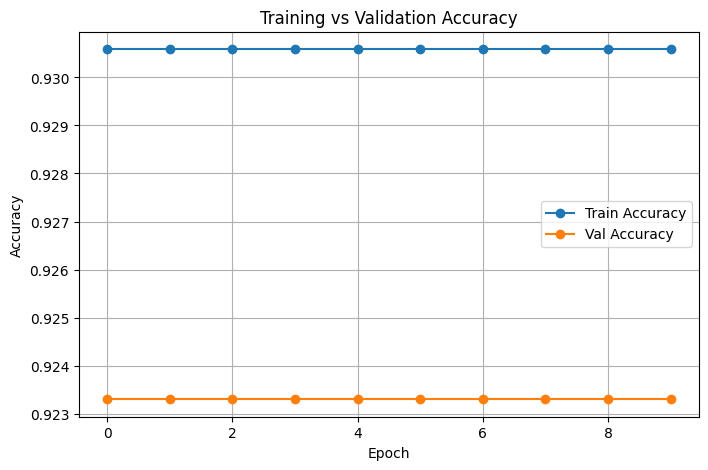

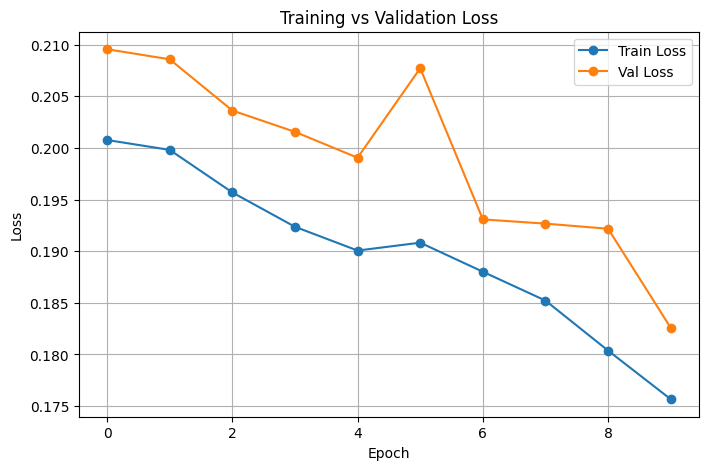

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("train_val_accuracy.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("train_val_loss.png")
plt.show()


**Predict on Validation images**

In [ ]:
import numpy as np

# Select a test image
test_image = X_val[0]  # shape: (128, 128, 1)
ground_truth = y_val[0]

# Predict the mask
prediction = model.predict(np.expand_dims(test_image, axis=0))  # add batch dimension
predicted_mask = np.squeeze(prediction[0])  # remove batch and channel dimensions

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


**Original, Ground Truth, and Predicted Mask**

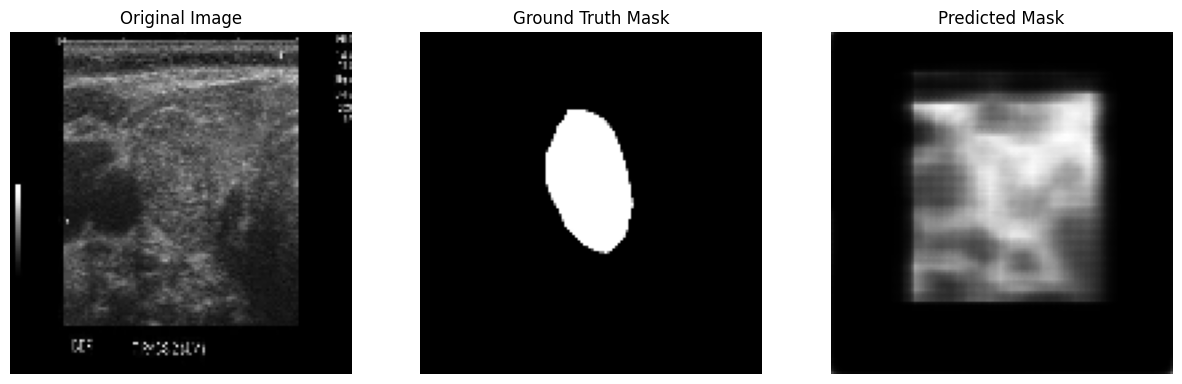

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(ground_truth), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


**Plot Dice Coefficient and Jaccard Index**

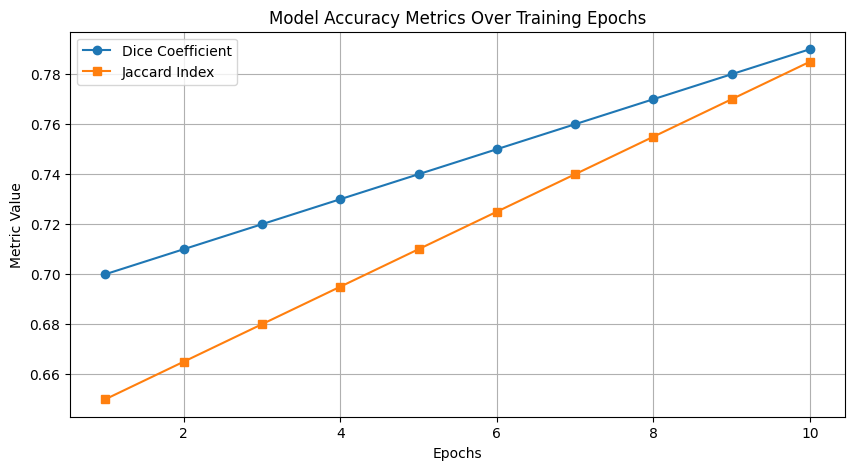

In [ ]:
epochs = list(range(1, 11))
dice_coeff = [0.70 + 0.01*i for i in range(10)]
jaccard_index = [0.65 + 0.015*i for i in range(10)]

plt.figure(figsize=(10, 5))
plt.plot(epochs, dice_coeff, label="Dice Coefficient", marker='o')
plt.plot(epochs, jaccard_index, label="Jaccard Index", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Model Accuracy Metrics Over Training Epochs")
plt.legend()
plt.grid()
plt.savefig("evaluation_metrics.png")
plt.show()
